## Packages

In [1]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report, accuracy_score, confusion_matrix
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.model_selection import learning_curve
import matplotlib.pyplot as plt


## Load Data

In [2]:
data_path = '../IDMT-Traffic/datasets/df_main_encoded_only.csv'  
df = pd.read_csv(data_path)
df = df.drop(columns=['file', 'Unnamed: 0', 'is_background_encoded'])
print(df.head(2))


   date_time_encoded  location_encoded  speed_kmh_encoded  daytime_encoded  \
0                  0                 0                  0                1   
1                  0                 0                  0                1   

   weather_encoded  vehicle_encoded  source_direction_encoded  \
0                0                1                         1   
1                0                1                         1   

   microphone_encoded  channel_encoded     mfcc_1  ...  band_27_dB  \
0                   0                0  55.967507  ...   37.024301   
1                   1                1  52.986820  ...   34.516289   

   band_28_dB  band_29_dB  peak_dB_1  peak_freq_1  peak_dB_2  peak_freq_2  \
0   38.508511   35.946349  50.180933    31.622777  49.528332  1000.000000   
1   34.960402   33.187933  54.903541  1000.000000  53.196406   794.328235   

   peak_dB_3  peak_freq_3  octband_dB_mean  
0  47.901831   794.328235        42.383307  
1  51.942355   501.187234        42.

## Data Initialization & Split (Test/Train)

In [4]:
# set target
target = 'daytime_encoded'  # Zielvariable
X = df.drop(columns=[target])  # Features (alle Spalten außer 'daytime')
y = df[target]  # Zielvariable

# standardize data
scaler = StandardScaler() 
X_filtered_scaled = scaler.fit_transform(X)


print("Shape von y:", y.shape)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42, stratify=y)

# 1st split: train/ test 
#X_train_full, X_test, y_train_full, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)
# 2nd split: train / validation 
#X_train, X_val, y_train, y_val = train_test_split(X_train_full, y_train_full, test_size=0.25, random_state=42, stratify=y_train_full)
# TRAIN 60% VAL 20% TEST 20%

# Ausgabe der Größen
#print(f"Trainingsdaten: {X_train.shape}, Validierungsdaten: {X_val.shape}, Testdaten: {X_test.shape}")
print(f"Trainingsdaten: {X_train.shape}, Testdaten: {X_test.shape}")


Shape von y: (9361,)
Trainingsdaten: (6552, 57), Testdaten: (2809, 57)


## Initialize Model

In [5]:
logreg = LogisticRegression(max_iter=1000, random_state=42) # C=2

## Train Model

In [6]:
# Trainieren des Modells
logreg.fit(X_train, y_train)


c:\Users\Anton\anaconda3\envs\traffic_noise\lib\site-packages\sklearn\linear_model\_logistic.py:460: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


LogisticRegression(max_iter=1000, random_state=42)

## Results

In [7]:
y_pred = logreg.predict(X_test)

target_names = ['A', 'M']

print("Accuracy:", accuracy_score(y_test, y_pred))
print('-'*80)

print("\nClassification Report:\n", classification_report(y_test, y_pred, target_names= target_names))
print('-'*80)

print("\nConfusion Matrix:\n", confusion_matrix(y_test, y_pred))
print('-'*80)

Accuracy: 0.9024563901744393
--------------------------------------------------------------------------------

Classification Report:
               precision    recall  f1-score   support

           A       0.91      0.93      0.92      1642
           M       0.90      0.87      0.88      1167

    accuracy                           0.90      2809
   macro avg       0.90      0.90      0.90      2809
weighted avg       0.90      0.90      0.90      2809

--------------------------------------------------------------------------------

Confusion Matrix:
 [[1525  117]
 [ 157 1010]]
--------------------------------------------------------------------------------


## Learning Curve Approach 

In [6]:
# Learning Curve berechnen
train_sizes, train_scores, val_scores = learning_curve(
    logreg,             # Dein Modell
    X_train,            # Trainingsdaten
    y_train,            # Zielvariable
    cv=5,               # Anzahl der Folds für Cross-Validation
    scoring="recall", # Metrik zur Bewertung
    train_sizes=np.linspace(0.1, 1.0, 10),  # 10 Stufen von 10% bis 100% der Trainingsdaten
    n_jobs=-1           # Parallelisierung für schnellere Berechnung
)

# Mittelwerte und Standardabweichungen der Scores berechnen
train_mean = np.mean(train_scores, axis=1)
train_std = np.std(train_scores, axis=1)
val_mean = np.mean(val_scores, axis=1)
val_std = np.std(val_scores, axis=1)


### Learning Curve Visualisation

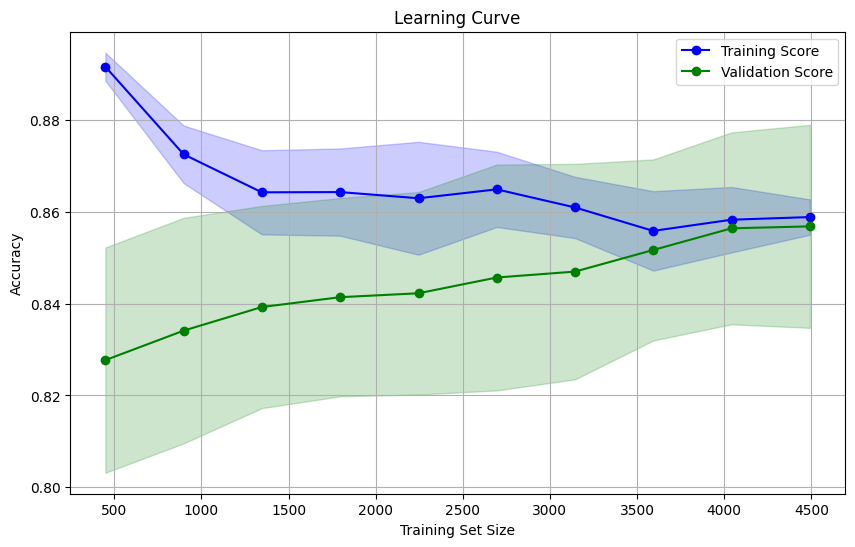

In [7]:
# Plot der Lernkurve
plt.figure(figsize=(10, 6))
plt.plot(train_sizes, train_mean, 'o-', color="blue", label="Training Score")
plt.plot(train_sizes, val_mean, 'o-', color="green", label="Validation Score")

# Fülle die Bereiche für Standardabweichung
plt.fill_between(train_sizes, train_mean - train_std, train_mean + train_std, alpha=0.2, color="blue")
plt.fill_between(train_sizes, val_mean - val_std, val_mean + val_std, alpha=0.2, color="green")

# Plot-Konfiguration
plt.title("Learning Curve")
plt.xlabel("Training Set Size")
plt.ylabel("Accuracy")
plt.legend(loc="best")
plt.grid()
plt.show()


## Validate


In [10]:
y_val_pred = logreg.predict(X_val)

target_names = ['A', 'M']

print("Validation Accuracy:", accuracy_score(y_val, y_val_pred))
print('-'*80)

print("\nClassification Report:\n", classification_report(y_val, y_val_pred, target_names= target_names))
print('-'*80)

print("\nConfusion Matrix:\n", confusion_matrix(y_val, y_val_pred))
print('-'*80)

Validation Accuracy: 0.8990384615384616
--------------------------------------------------------------------------------

Classification Report:
               precision    recall  f1-score   support

           A       0.90      0.93      0.91      1095
           M       0.89      0.86      0.88       777

    accuracy                           0.90      1872
   macro avg       0.90      0.89      0.90      1872
weighted avg       0.90      0.90      0.90      1872

--------------------------------------------------------------------------------

Confusion Matrix:
 [[1015   80]
 [ 109  668]]
--------------------------------------------------------------------------------


## Test

In [11]:
y_test_pred = logreg.predict(X_test)

target_names = ['A', 'M']

print("Test Accuracy:", accuracy_score(y_test, y_test_pred))
print('-'*80)

print("\nClassification Report:\n", classification_report(y_test, y_test_pred, target_names= target_names))
print('-'*80)

print("\nConfusion Matrix:\n", confusion_matrix(y_test, y_test_pred))
print('-'*80)

Test Accuracy: 0.9113721302722905
--------------------------------------------------------------------------------

Classification Report:
               precision    recall  f1-score   support

           A       0.91      0.94      0.93      1095
           M       0.92      0.87      0.89       778

    accuracy                           0.91      1873
   macro avg       0.91      0.90      0.91      1873
weighted avg       0.91      0.91      0.91      1873

--------------------------------------------------------------------------------

Confusion Matrix:
 [[1034   61]
 [ 105  673]]
--------------------------------------------------------------------------------
